# Taylor Cina D213 Performance Assessment

## Task 2

In [464]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import re
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input

#nltk downloads
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
stopwords = stopwords.words('english')

#Data exploration
df = pd.read_csv("amazon_cells_labelled.txt", sep='\t', header=None)
df.columns = ["Review", "Sentiment"]
print(df.shape)
print(df.head(5))

(1000, 2)
                                              Review  Sentiment
0  So there is no way for me to plug it in here i...          0
1                        Good case, Excellent value.          1
2                             Great for the jawbone.          1
3  Tied to charger for conversations lasting more...          0
4                                  The mic is great.          1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mugenri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mugenri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mugenri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [306]:
#Text Cleaning

#missing values
print("Missing Values:")
print(df.isna().sum(), "\n")

#list of unique characters
chars = []
for review in df['Review']:
    for char in list(review):
        if char not in chars:
            chars.append(char)
print(chars)

#review cleaning and tokenization
cleaned_reviews = []
for review in df['Review']:
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()

    #tokenization
    review = word_tokenize(review)

    #normalization
    review = [nltk.WordNetLemmatizer().lemmatize(word) for word in review]
    review = [word for word in review if not word in stopwords]

    cleaned_reviews.append(review)

#print(cleaned_reviews)
df['Review'] = cleaned_reviews
print(df.head(5))

#size of vocabulary
tok = Tokenizer()
tok.fit_on_texts(df["Review"])
vocab_size = len(tok.word_index) + 1
embed_len = math.ceil(vocab_size**0.25)
print("Vocabulary size: ", vocab_size)
print("Embedding length: ", embed_len)

Missing Values:
Review       0
Sentiment    0
dtype: int64 

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']']
                                              Review  Sentiment
0              [way, plug, u, unless, go, converter]          0
1                     [good, case, excellent, value]          1
2                                   [great, jawbone]          1
3  [tied, charger, conversation, lasting, minute,...          0
4                                       [mic, great]          1
Vocabulary size:  1568
Embedding length:  7


In [307]:
#find max length for padding
max_len = max(map(len, df.Review))
print("Max length: ", max_len)

#train test split
X = np.array(df.Review)
y = df.Sentiment.values
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = seed, stratify = y)

print("Training Size: ", X_train.shape)
print("Test Size: ", X_test.shape)

#Sequencing and Padding
X_train = tok.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_test = tok.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

#convert to np array for use in model
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train[0])

Max length:  17
Training Size:  (800,)
Test Size:  (200,)
[  34  155  640 1304 1305  310   65  255    0    0    0    0    0    0
    0    0    0]


In [308]:
#save to file
pd.DataFrame(X_train).to_csv("X_train.csv")
pd.DataFrame(y_train).to_csv("y_train.csv")
pd.DataFrame(X_test).to_csv("X_test.csv")
pd.DataFrame(y_test).to_csv("y_test.csv")

In [457]:
#Model
num_epochs = 20

early_stop = EarlyStopping(patience = 6)

model = Sequential([
    Input(shape=(17,)),
    Embedding(vocab_size, embed_len),
    GlobalAveragePooling1D(),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ (None, 17, 7)          │        10,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_27     │ (None, 7)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 50)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,478 (44.84 KB)

 Trainable params: 11,478 (44.84 KB)

 Non-trainable params: 0 (0.00 B)

In [458]:
#Fit model
history = model.fit(X_train, y_train, epochs = num_epochs, validation_split = 0.3, callbacks=[early_stop], verbose=True)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5241 - loss: 0.6935 - val_accuracy: 0.5958 - val_loss: 0.6928
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6682 - loss: 0.6922 - val_accuracy: 0.6208 - val_loss: 0.6915
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6696 - loss: 0.6895 - val_accuracy: 0.6958 - val_loss: 0.6893
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6652 - loss: 0.6848 - val_accuracy: 0.7125 - val_loss: 0.6853
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7679 - loss: 0.6767 - val_accuracy: 0.7542 - val_loss: 0.6774
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8388 - loss: 0.6602 - val_accuracy: 0.7500 - val_loss: 0.6648
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9358 - loss: 0.6335 - val_accuracy: 0.7833 - val_loss: 0.6461
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9029 - loss: 0.5942 - val_accuracy: 0.7167 - val_loss

In [459]:
#Save and load model
model.save('nlp_model.keras')
nlp_model = load_model('nlp_model.keras')

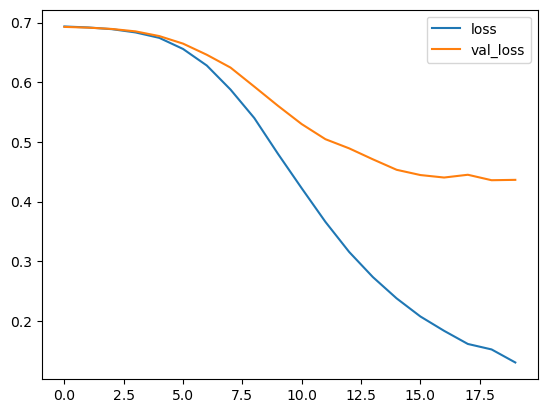

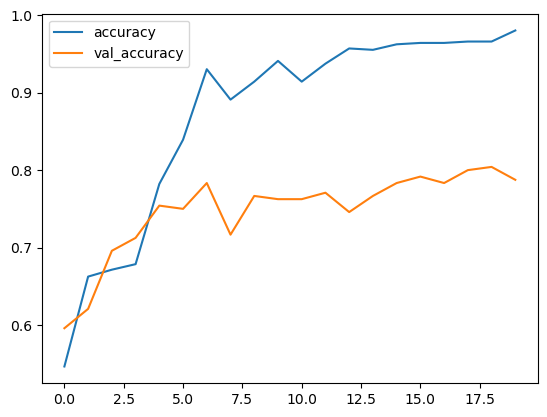

In [ ]:
#Training visualizations
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [462]:
#Evaluate
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Loss: ", score[0], "/ Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Loss: ", score[0], "/ Testing Accuracy: ", score[1])

Training Loss:  0.2148359715938568 / Training Accuracy:  0.9237499833106995
Testing Loss:  0.4782872796058655 / Testing Accuracy:  0.8100000023841858
